## Diversity in Retrieval
In the previous experiment we talked about the relavence in search. <br>
For any retrievel system relevance is as important as diversity.<br>
In this experiment we try to incorporate diversity in our search trying to keep it as relevant as possible.

KNN was apt for the previous experiment whereas approximate NN would be more suitable for our present setting.

![title](picture.png)

Source : Vidyadhar Rao, Prateek Jain and C. V. Jawahar - Diverse Yet Efficient Retrieval using Locality Sensitive Hashing Proceedings of the 2016 ACM on International Conference on Multimedia Retrieval


####  LSHF(Locality sensitive Hashing) is an algorithm for solving the approximate or exact Near Neighbor Search in high dimensional spaces.
https://medium.com/engineering-brainly/locality-sensitive-hashing-explained-304eb39291e4

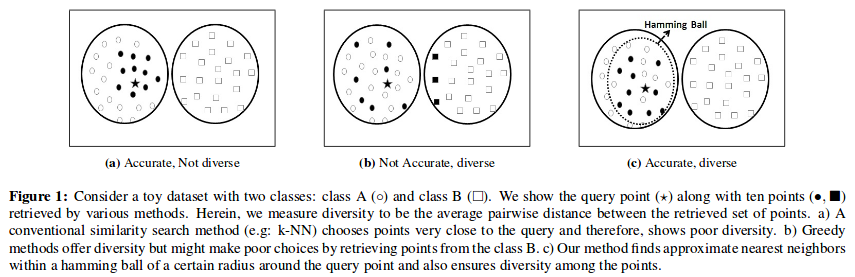

In [1]:
from IPython.display import Image, display
display(Image('picture.png'))

In [2]:
# The below are wrapper functions used to connect to your drive and this needs to be run once (i.e. once every new session or possibily refreshes for every 24 hours)

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Authentication for your google drive
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

# Authentication for the wrapper libraries  or possibily refreshes for every 24 hours)

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


'apt-get' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.
The system cannot find the path specified.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


ModuleNotFoundError: No module named 'google.colab'

In [0]:
!mkdir -p MyDrive
!google-drive-ocamlfuse MyDrive

In [25]:
%cd MyDrive

/content/MyDrive


In [26]:
%cd Session14

/content/MyDrive/Session14


In [27]:
!ls

Experiment2_A.ipynb  MyDrive	  wikipedia_dataset
Experiment2_B.ipynb  picture.png


In [7]:
!pip3 install lxml

    100% |████████████████████████████████| 5.7MB 5.6MB/s 


In [0]:
from lxml import etree
from glob import glob
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
import numpy as np
import random
from bs4 import BeautifulSoup as Soup
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import os
from IPython.display import clear_output
from IPython.display import display, HTML
from nltk.corpus import reuters 
from sklearn.neighbors import LSHForest
import matplotlib.pyplot as plt 

In [10]:
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to /content/nltk_data...


True

## Dataset Description - Reuters##

In [11]:
def collection_stats():
    # List of documents
    documents = reuters.fileids()
    print(str(len(documents)) + " documents");
 
    train_docs = list(filter(lambda doc: doc.startswith("train"),
                        documents));
    print(str(len(train_docs)) + " total train documents");
 
    test_docs = list(filter(lambda doc: doc.startswith("test"),
                       documents));
    print(str(len(test_docs)) + " total test documents");
 
    # List of categories
    categories = reuters.categories();
    print(str(len(categories)) + " categories");
    print(categories)
    # Documents in a category
    category_docs = reuters.fileids("acq");
 
    # Words for a document
    document_id = category_docs[0]
    document_words = reuters.words(category_docs[0]);
    print(document_words);  
 
    # Raw document
    print(reuters.raw(document_id)[:500])
collection_stats()

10788 documents
7769 total train documents
3019 total test documents
90 categories
['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']
['SUMIT

In [12]:
cat = reuters.categories()
docs = []
qid = []
for i in range(len(cat)):
    for doc_id in reuters.fileids(cat[i]):
        docs.append(reuters.raw(doc_id))
        qid.append(i)
    
print(len(docs), len(qid))   

13328 13328


## Construct feature vector from documents

In [0]:
stoplist = open('wikipedia_dataset/stopwords.txt').read().splitlines()

In [0]:
## TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words=stoplist, min_df=0.0005)
matrix = vectorizer.fit_transform(docs)
doc_vectors = matrix.todense()
doc_vectors = np.array(doc_vectors)
vocab = vectorizer.vocabulary_

In [15]:
print(doc_vectors.shape, len(qid))

(13328, 9329) 13328


### 1. Weighted KNN 
- Initially display random 20 documents and get user click
- Run the KNN Algorithm and chose 100 nearest neighbours
- Define a weight matrix to get the ranking of the 100 relavent vectors based on similarity

Given $m$ - dimensional query $q$ and document $d_{i}$, the weighted similarity is calculated as follows <br> 
$q = (q_{1}, q_{2}, \cdots, q_{m})$ <br>
$d_{i} = (d_{1}, d_{2}, \cdots, c_{m})$ <br>
$$Similarity = w^T d'_{i}$$ where ,
$$d'_{i} = \frac{q * d_{i}}{\parallel q \parallel \parallel d_{i} \parallel}  $$

In [16]:
## Fit KNN
KNN = NearestNeighbors(100, 0.4, metric = 'cosine')
KNN.fit(doc_vectors)
neighbours = KNN.kneighbors(doc_vectors,return_distance=False)
print(neighbours.shape)

(13328, 100)


In [0]:
## Fit LSHN
lshf = LSHForest(random_state=42)
lshf.fit(doc_vectors)
neighbours_lshf = lshf.kneighbors(doc_vectors, n_neighbors=100, return_distance=False)

/home/manisha/Documents/OnlineLearning/venv/lib/python3.5/site-packages/sklearn/neighbors/approximate.py:220: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [0]:
# Number of articles displayed at max 100
num = 10
div = 1 # Change the value to see the effect

1. The variable $neighbours$ stores the KNN. 
2. The variable $neighbours\_lshf$ stores the Approximate NN.

To compare both the above models, do the changes as prompted below in the comments <br>
Run the code snippet below with each of the above and observe how the search results vary

In [19]:
def to_display(doc_ids, init= False):
    if init == True:
        ix = random.sample(range(0, len(doc_vectors)), num)
    else:
        ix = doc_ids
    
    df = pd.DataFrame(columns=['index', 'Article','category'])
    df['index'] = ix
    df['Article'] = [docs[i][:100] for i in ix]
    df['category'] = [cat[qid[i]-1][:-1] for i in ix] 
    clear_output()
    display(HTML(df.to_html()))
    return ix


index = to_display([],init= True)
doc_id = input("Select the index of the article you would like to read or type 'stop' if you want end the search")
doc_id = int(doc_id)

ctr = 0
## initialize the weight vector to ones
weights = np.ones((doc_vectors.shape[1],1))
while (True):   
    query_doc = doc_vectors[doc_id].reshape(1, doc_vectors.shape[1])
    ## REPLACE WITH neighbours_lshf to use ANN instead of KNN
    relevant_docs_ix = neighbours[doc_id]
    relevant_docs = doc_vectors[relevant_docs_ix]
    ## Calculate Similarity
    new_relevance = (query_doc[0] * relevant_docs) / (np.linalg.norm(relevant_docs) * np.linalg.norm(query_doc) )
    similarity  = np.matmul(new_relevance , weights)
    ## Return the num most ranked doc ids
    ranked_docs_ix = relevant_docs_ix[np.argsort(similarity[:,0])]
    index = to_display(ranked_docs_ix[:num])
    doc_id = input("Select the index of the article you would like to read or type 'stop' if you want end the search:")
    if doc_id == 'stop':
        break    
    doc_id = int(doc_id)
    weights = weights + div * doc_vectors[doc_id].reshape(doc_vectors.shape[1], 1)
    weights = weights/ np.linalg.norm(weights)
    ctr += 1

print('Enjoy your Article')



,index,Article,category
0,12483,U.S. STOCK MARKET OVERREACTS TO TARIFFS - YEUT...,ti
1,12507,JAPAN WARNS OF ANTI-U.S. SENTIMENT IN TRADE RO...,ti
2,12347,TRADE ISSUES STRAINING EC'S PATIENCE WITH JAPA...,ti
3,12484,ENVOY ADVISES NAKASONE TO PREPARE FOR U.S. VIS...,ti
4,1977,RICHARDSON &lt;RELL>TO BUY ITALIAN SEMICONDUCT...,zin
5,12478,U.S./JAPAN TRADE WAR NOT IN UK'S INTEREST - LA...,ti
6,12490,"REAGAN RENEWS ANTI-PROTECTIONISM STAND, WHITE ...",ti
7,11180,LYNG OPENS JAPAN TALKS ON FARM TRADE BARRIERS\...,oilsee
8,12360,LYNG OPENS JAPAN TALKS ON FARM TRADE BARRIERS\...,ti
9,2589,LYNG OPENS JAPAN TALKS ON FARM TRADE BARRIERS\...,bo


Select the index of the article you would like to read or type 'stop' if you want end the search:stop
Enjoy your Article


### 2. Rocchio Algorithm
- Initially random articles are displayed
- Select an index value based on your choice
- Select all the indices of relevant documents
- Update the centroid of relavant vector as shown in the formula above
- Display the nearest neighbours of the relavant vector

- $alpha$- how close to relavant 
- $beta$ - how far from non relevant

Ideally we would like to have high $alpha$ and low $beta$

In [20]:
alpha = 1.0
beta = 0.5
index = to_display([],init= True)
while(True):
    doc_id = input("Select the index of the article you would like to read or type 'stop' if you want end the search:")
    if doc_id == 'stop':
        break
    print("Enter the indices, comma separated for relevant documents:")
    R = [int(x) for x in input().split(',')]
    NR = [i for i in index if i not in R]
    doc_id = int(doc_id)
    query_doc = doc_vectors[doc_id].reshape(1, doc_vectors.shape[1])
    R_docs = doc_vectors[R]
    NR_docs = doc_vectors[NR]

    q_new = query_doc + (alpha * np.sum(R_docs, 0)/len(R)) - (beta * np.sum(NR_docs, 0)/len(NR))
    print(q_new.shape)
    ## Replace KNN with lshf to find the ANN instead of KNN
    retrieved = KNN.kneighbors(q_new, return_distance=False)
    index = to_display(retrieved[0][:num])
    
print('Enjoy your article')

,index,Article,category
0,605,JACOBS SELLS STAKE IN GILLETTE &lt;GS>\n Minn...,zin
1,3452,OIL MARKETS SHOW RESPECT FOR NEW OPEC ACCORD\n...,cp
2,8088,OIL MARKETS SHOW RESPECT FOR NEW OPEC ACCORD\n...,ear
3,10861,OIL MARKETS SHOW RESPECT FOR NEW OPEC ACCORD\n...,money-suppl
4,471,IRWIN JACOBS HAS GILLETTE &lt;GS> STAKE\n Inv...,zin
5,394,GILLETTE &lt;GS> GETS OFFER FROM REVLON &lt;RE...,zin
6,468,IRWIN JACOBS SAYS HE HOLDS LESS THAN FIVE PCT ...,zin
7,1812,FRANCE APPROVES WATERMAN ACQUISITION BY GILLET...,zin
8,418,GILLETTE &lt;GS> SEEN OBJECT OF GLOBAL BIDDING...,zin
9,383,UNILEVER DECLINES COMMENT ON GILLETTE BID RUMO...,zin


Select the index of the article you would like to read or type 'stop' if you want end the search:stop
Enjoy your article
